## Importing

In [3]:
# Need to install technologies below for local usage in Colab.
# !pip install torchmetrics
# !pip install catboost

In [4]:
import pandas as pd
import numpy as np
import torch
import warnings

from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from torchmetrics import MultioutputWrapper, R2Score

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from catboost import CatBoostRegressor

import matplotlib.pyplot as plt
import seaborn as sns

## Data Loading

In [5]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

## Data Preprocessing

In [6]:
print('train: ',train_data.shape)
print('test: ',test_data.shape)

train:  (455, 222)
test:  (100, 20)


In [7]:
train_data.head()

,group,sample,depth,por,den,ct_1,ct_2,ct_3,ct_4,ct_5,...,pc_91,pc_92,pc_93,pc_94,pc_95,pc_96,pc_97,pc_98,pc_99,pc_100
0,3,52,1660.178974,18.556209,2.740942,1971.579998,2396.714551,2799.219912,1951.977330,2041.857394,...,20517.973164,23072.031367,25918.199746,29130.680234,32741.818105,36776.940391,41337.948828,46440.194570,52182.348633,58608.434023
1,4,92,3890.779426,8.555400,2.834776,2513.180531,3001.782975,2348.160682,2414.636280,2798.706138,...,4178.079326,4564.280930,4987.905991,5457.903966,5976.209199,6537.572468,7149.014724,7826.130471,8559.884813,9368.567796
2,3,90,2287.441253,-0.169935,2.761468,2274.773580,1083.899155,2974.647775,2713.863889,2381.094609,...,20522.705605,23075.290605,25927.208926,29136.474492,32743.575156,36780.525273,41344.256875,46461.810508,52207.803164,58651.855859
3,3,49,2144.788740,28.192998,2.637605,1776.270868,2374.721334,2670.367528,2814.751969,2919.311685,...,20522.544570,23075.227422,25928.721426,29137.418496,32742.759414,36779.554531,41344.410508,46463.711484,52212.429531,58661.142344
4,2,65,3754.453151,4.136069,2.900202,1787.771840,1893.016733,2818.411074,1542.522104,2246.952313,...,4223.781546,4615.144614,5045.280631,5520.831567,6044.115860,6611.085441,7231.857753,7913.697529,8657.308785,9475.725759


In [8]:
test_data.head()

,group,sample,depth,por,den,ct_1,ct_2,ct_3,ct_4,ct_5,ct_6,ct_7,permeability,ntg,thickness_effective,x,y,lithology,gr,rhob
0,6,0,2541.519832,17.574182,2.721184,2397.858599,2530.129882,2419.635540,2410.149830,2378.142534,2245.973152,2419.142862,9.686923,0.642302,8.331449,19250,4113,limestone,38.502328,2.709270
1,6,1,2492.499349,15.601646,2.731073,2493.479588,2381.180205,2374.025753,2122.706339,2535.031736,1926.894657,2213.529371,25.113567,0.202864,6.434557,19250,4113,clay sandstone,41.279069,2.629994
2,6,2,2499.758962,9.799370,2.750291,2353.105272,2557.985901,2173.083377,2302.371534,2270.180822,2546.064601,2379.507012,14.627389,0.493521,7.124782,19250,4113,clay sandstone,34.065870,2.640400
3,6,3,2484.952580,17.577824,2.644786,2577.886453,2405.878549,2541.314684,2433.153095,2541.348799,2471.677155,2431.742461,3.387930,0.734310,7.613031,19250,4113,siltstome,35.681114,2.624468
4,6,4,2520.922067,7.463433,2.677037,2367.054324,2369.093221,2143.892103,2762.000785,2747.865591,2242.994301,2369.544989,16.088282,0.753219,7.024979,19250,4113,clay sandstone,32.158592,2.670718


In [9]:
print('Non-target variables: ')
non_target = set(train_data.columns) & set(test_data.columns)
print(sorted(non_target))

print('Target variables: ')
target = set(train_data.columns) - set(test_data.columns)
print(sorted(target))

Non-target variables: 
['ct_1', 'ct_2', 'ct_3', 'ct_4', 'ct_5', 'ct_6', 'ct_7', 'den', 'depth', 'gr', 'group', 'lithology', 'ntg', 'permeability', 'por', 'rhob', 'sample', 'thickness_effective', 'x', 'y']
Target variables: 
['bv_0', 'bv_1', 'bv_10', 'bv_100', 'bv_11', 'bv_12', 'bv_13', 'bv_14', 'bv_15', 'bv_16', 'bv_17', 'bv_18', 'bv_19', 'bv_2', 'bv_20', 'bv_21', 'bv_22', 'bv_23', 'bv_24', 'bv_25', 'bv_26', 'bv_27', 'bv_28', 'bv_29', 'bv_3', 'bv_30', 'bv_31', 'bv_32', 'bv_33', 'bv_34', 'bv_35', 'bv_36', 'bv_37', 'bv_38', 'bv_39', 'bv_4', 'bv_40', 'bv_41', 'bv_42', 'bv_43', 'bv_44', 'bv_45', 'bv_46', 'bv_47', 'bv_48', 'bv_49', 'bv_5', 'bv_50', 'bv_51', 'bv_52', 'bv_53', 'bv_54', 'bv_55', 'bv_56', 'bv_57', 'bv_58', 'bv_59', 'bv_6', 'bv_60', 'bv_61', 'bv_62', 'bv_63', 'bv_64', 'bv_65', 'bv_66', 'bv_67', 'bv_68', 'bv_69', 'bv_7', 'bv_70', 'bv_71', 'bv_72', 'bv_73', 'bv_74', 'bv_75', 'bv_76', 'bv_77', 'bv_78', 'bv_79', 'bv_8', 'bv_80', 'bv_81', 'bv_82', 'bv_83', 'bv_84', 'bv_85', 'bv_86', 

In [10]:
train_data_target = train_data[target]
train_data_non_target = train_data[non_target]

train_data_non_target = train_data_non_target.reindex(sorted(train_data_non_target.columns), axis=1)
test_data = test_data.reindex(sorted(test_data.columns), axis=1)

In [11]:
train_data_non_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 455 entries, 0 to 454
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ct_1                 455 non-null    float64
 1   ct_2                 455 non-null    float64
 2   ct_3                 455 non-null    float64
 3   ct_4                 455 non-null    float64
 4   ct_5                 455 non-null    float64
 5   ct_6                 455 non-null    float64
 6   ct_7                 455 non-null    float64
 7   den                  455 non-null    float64
 8   depth                455 non-null    float64
 9   gr                   455 non-null    float64
 10  group                455 non-null    int64  
 11  lithology            455 non-null    object 
 12  ntg                  455 non-null    float64
 13  permeability         455 non-null    float64
 14  por                  455 non-null    float64
 15  rhob                 455 non-null    flo

In [12]:
train_data_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 455 entries, 0 to 454
Columns: 202 entries, bv_85 to pc_47
dtypes: float64(202)
memory usage: 718.2 KB


In [13]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ct_1                 100 non-null    float64
 1   ct_2                 100 non-null    float64
 2   ct_3                 100 non-null    float64
 3   ct_4                 100 non-null    float64
 4   ct_5                 100 non-null    float64
 5   ct_6                 100 non-null    float64
 6   ct_7                 100 non-null    float64
 7   den                  100 non-null    float64
 8   depth                100 non-null    float64
 9   gr                   100 non-null    float64
 10  group                100 non-null    int64  
 11  lithology            100 non-null    object 
 12  ntg                  100 non-null    float64
 13  permeability         100 non-null    float64
 14  por                  100 non-null    float64
 15  rhob                 100 non-null    floa

In [14]:
print('train unqiue: ', sorted(list(train_data_non_target['lithology'].unique())))
print('test unique:  ', sorted(list(test_data['lithology'].unique())))

train unqiue:  ['clay sandstone', 'limestone', 'sandstone', 'shale', 'siltstome']
test unique:   ['clay sandstone', 'limestone', 'sandstone', 'siltstome']


In [15]:
label_changing = {'clay sandstone': 1,'limestone': 2,'sandstone': 3,'shale': 4,'siltstome': 5}

In [16]:
pd.options.mode.chained_assignment = None

def replacing(data):
  for i in range(len(data)):
    data['lithology'][i] = label_changing[data['lithology'][i]]

replacing(train_data_non_target)
replacing(test_data)

In [17]:
train_data_non_target['lithology'] = train_data_non_target['lithology'].astype(float)
test_data['lithology'] = test_data['lithology'].astype(float)

## Overfitting Check

In [18]:
xtrain, xtest, ytrain, ytest = train_test_split(train_data_non_target, train_data_target, 
    test_size=0.3, shuffle = True, random_state = 10)

# create a validation set
xtrain, xval, ytrain, yval = train_test_split(xtrain, ytrain, 
    test_size=0.2, random_state= 10) 

In [19]:
lr = LinearRegression()
model = MultiOutputRegressor(estimator=lr)

model.fit(xtrain, ytrain)

ypred_train = model.predict(xval)
ypred_test = model.predict(xtest)

In [20]:
# make a function to evaluate models
def multirmse(ytest, ypred):
    rmse = []
    for prediction in list(ypred.columns):       
        MSE = mean_squared_error(np.array(ytest[prediction]), np.array(ypred[prediction]))
        RMSE = np.sqrt(MSE)
        rmse.append(RMSE)
    return rmse

def evaluation(ytest, ypred):
    res = []

    ytest = torch.tensor(ytest.to_numpy())
    ypred = torch.tensor(ypred)
    r2score = MultioutputWrapper(R2Score(), train_data_target.shape[1])
    r2_test = np.array([i.item() for i in r2score(ytest, ypred)])
    r2_test = np.nan_to_num(r2_test, nan=0)

    rmse = np.array(multirmse(pd.DataFrame(ytest), pd.DataFrame(ypred))).mean()

    res.append(round(np.mean(r2_test),2))
    res.append(round(mean_absolute_error(ytest, ypred),2))
    res.append(round(mean_squared_error(ytest, ypred)))
    res.append(round(rmse,2))

    return res


In [21]:
overfitting = dict()

overfitting['train'] = evaluation(yval, ypred_train)
overfitting['test'] = evaluation(ytest, ypred_test)

In [22]:
metrics = ['R2','MAE','MSE','RMSE']
overfitting_stat = pd.DataFrame.from_dict(overfitting, orient='index' ,columns=metrics)

In [23]:
overfitting_stat = overfitting_stat.T

In [24]:
overfitting_stat['Diff(%)'] = round(abs(((overfitting_stat['train']-overfitting_stat['test'])/overfitting_stat['train'])*100),1)

In [25]:
# Conclusion: The problem of overfitting is not likely to affect the model.
overfitting_stat

,train,test,Diff(%)
R2,0.73,0.75,2.7
MAE,92.80,103.54,11.6
MSE,265027.00,299050.00,12.8
RMSE,146.57,154.88,5.7


## Feature Selection

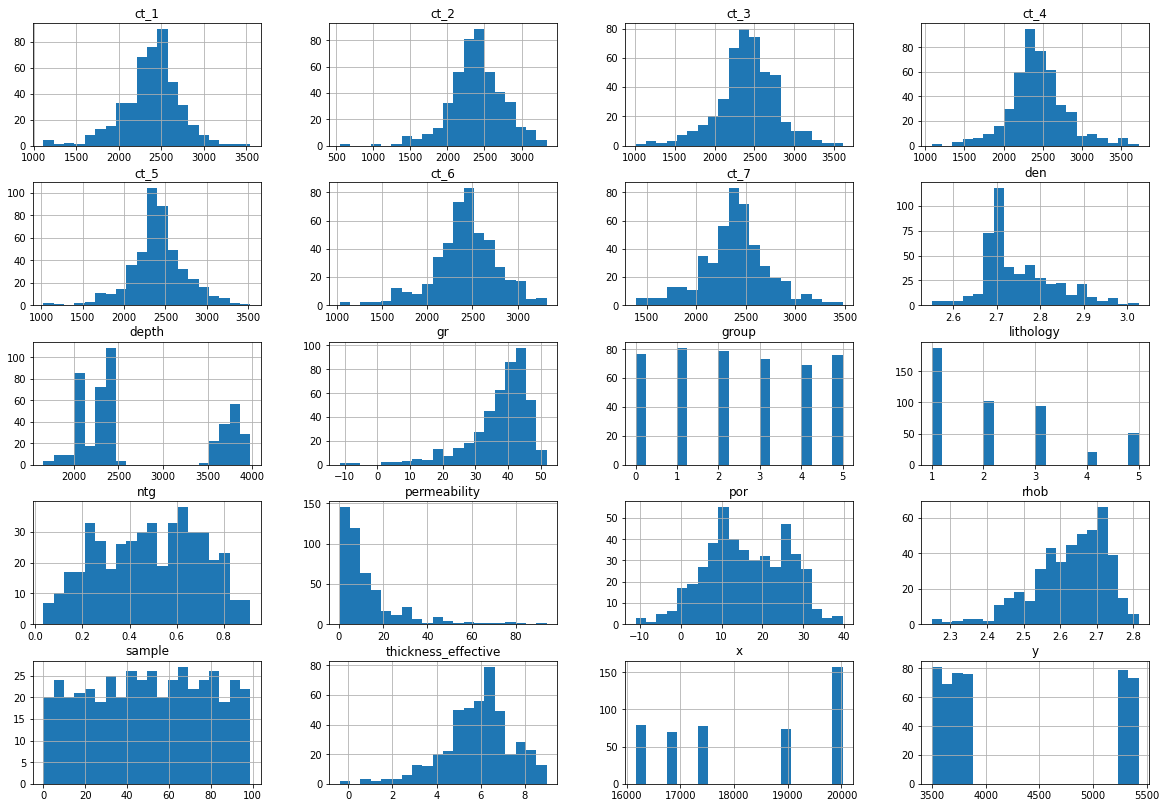

In [26]:
train_data_non_target.hist(figsize=(20,14), bins=20)
plt.show()

In [27]:
train_data_non_target = train_data_non_target.drop(columns=['ct_1','ct_2', 'ct_3', 'ct_4', 'ct_5', 'ct_6', 'ct_7'])

## Linear Regression

In [28]:
xtrain, xtest, ytrain, ytest_lr = train_test_split(train_data_non_target, train_data_target, 
                                                   test_size=0.3, random_state=40)

scaler = MinMaxScaler()
xtrain = scaler.fit_transform(xtrain)
xtest = scaler.transform(xtest)

lr = LinearRegression()
model = MultiOutputRegressor(estimator=lr)

model.fit(xtrain, ytrain)
ypred_lr = model.predict(xtest)

In [29]:
# Test results of the improved linear regression model:
ilr = pd.DataFrame(evaluation(ytest_lr, ypred_lr),index=metrics, columns=['Improved LR'])
print(ilr,'\n')

# Сompare this improved LR model with the test part of the previous basic LR model. 
compare = pd.concat([overfitting_stat['test'], ilr], join='inner',axis=1) 
compare.rename(columns={'test':'Basic LR','ilr':'Improved LR'})

      Improved LR
R2           0.77
MAE         84.22
MSE     187924.00
RMSE       122.82 



,Basic LR,Improved LR
R2,0.75,0.77
MAE,103.54,84.22
MSE,299050.00,187924.00
RMSE,154.88,122.82


## K-Nearest Neighbors 

In [30]:
xtrain, xtest, ytrain, ytest_knn = train_test_split(train_data_non_target, train_data_target, 
                                                   test_size=0.3, random_state= 40)

scaler = StandardScaler()
xtrain = scaler.fit_transform(xtrain)
xtest = scaler.transform(xtest)

knn = KNeighborsRegressor(n_neighbors=5)

knn.fit(xtrain, ytrain)
ypred_knn = knn.predict(xtest)

In [31]:
# Test results of the knn model:
iknn = pd.DataFrame(evaluation(ytest_knn, ypred_knn),index=metrics, columns=['KNN'])
iknn

,KNN
R2,0.69
MAE,6.86
MSE,1057.00
RMSE,12.52


## Decision Tree

In [32]:
xtrain, xtest, ytrain, ytest_dt = train_test_split(train_data_non_target, train_data_target, 
                                                   test_size=0.3, random_state=20)

scaler = MinMaxScaler()
xtrain = scaler.fit_transform(xtrain)
xtest = scaler.transform(xtest)

dt = DecisionTreeRegressor(max_depth=3)

dt.fit(xtrain, ytrain)
ypred_dt = dt.predict(xtest)

In [33]:
# Test results of the decision tree model:
idt = pd.DataFrame(evaluation(ytest_dt, ypred_dt),index=metrics, columns=['DT'])
idt

,DT
R2,0.67
MAE,8.01
MSE,1645.00
RMSE,15.10


## Catboost

In [34]:
xtrain, xtest, ytrain, ytest_cb = train_test_split(train_data_non_target, train_data_target, 
                                                   test_size=0.3, random_state=20)

scaler = StandardScaler()
xtrain = scaler.fit_transform(xtrain)
xtest = scaler.transform(xtest)

cb = CatBoostRegressor(iterations=100, learning_rate=1)
cb = MultiOutputRegressor(estimator=cb)

cb.fit(xtrain, ytrain, verbose=False)
ypred_cb = cb.predict(xtest)

In [35]:
# Test results of the catboost model:
icb = pd.DataFrame(evaluation(ytest_cb, ypred_cb),index=metrics, columns=['CB'])
icb

,CB
R2,0.80
MAE,73.96
MSE,201481.00
RMSE,127.08


## Visualizing results

<Figure size 432x288 with 0 Axes>

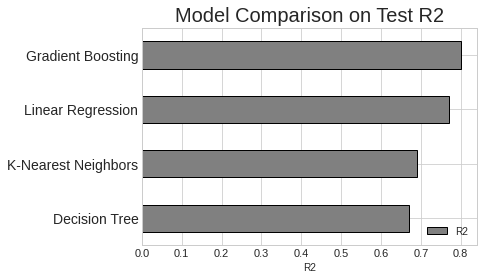

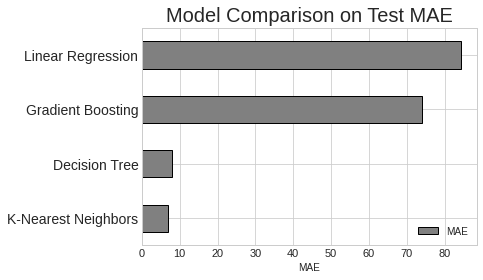

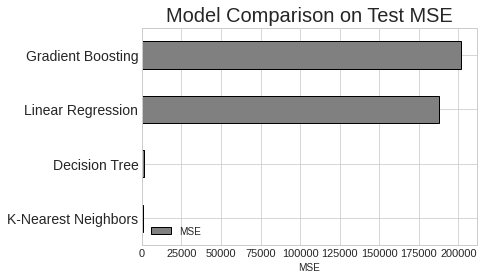

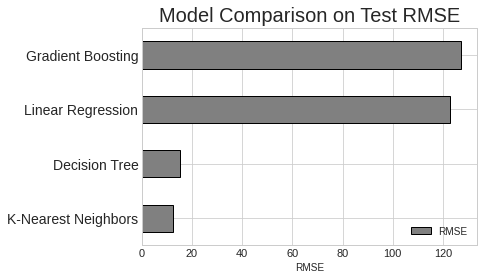

In [36]:
fig = plt.figure()
plt.style.use('seaborn-whitegrid')

def cp_model_comparison(metric):
  model_comparison = pd.DataFrame({'model': ['Linear Regression', 
                                           'K-Nearest Neighbors',
                                           'Decision Tree', 
                                           'Gradient Boosting'] ,
                                 metric : [ilr.T[metric].item(), iknn.T[metric].item(),
                                        idt.T[metric].item(), icb.T[metric].item()]
                                 })
  model_comparison = model_comparison.sort_values(metric)
  model_comparison.plot(x = 'model', 
                         y = metric, 
                         kind = 'barh',
                         color = 'grey', 
                         edgecolor = 'black')
  
  plt.ylabel('') 
  plt.yticks(size = 14)
  plt.xlabel(metric)
  plt.xticks(size = 11)
  plt.title(f'Model Comparison on Test {metric}', size = 20)
  plt.show()

cp_model_comparison('R2')
print()
cp_model_comparison('MAE')
print()
cp_model_comparison('MSE')
print()
cp_model_comparison('RMSE')


## Best Model

In [37]:
lr_info = [ilr.T['R2'].item(), ilr.T['MAE'].item(), ilr.T['MSE'].item(), ilr.T['RMSE'].item()]
knn_info = [iknn.T['R2'].item(), iknn.T['MAE'].item(), iknn.T['MSE'].item(), iknn.T['RMSE'].item()]
dt_info = [idt.T['R2'].item(), idt.T['MAE'].item(), idt.T['MSE'].item(), idt.T['RMSE'].item()]
cb_info = [icb.T['R2'].item(), icb.T['MAE'].item(), icb.T['MSE'].item(), icb.T['RMSE'].item()]

In [38]:
stat = {'Linear Regression':lr_info, 'K-Nearest Neighbors':knn_info,
        'Decision Tree':dt_info, 'Catboost':cb_info}

In [39]:
stat = sorted(stat.items(), key=lambda x: (-1*x[1][1], -1*x[1][2], x[1][0], -1*x[1][3]), reverse=True)

In [40]:
stat = pd.DataFrame(dict(stat)).T

In [41]:
stat.rename({0:metrics[0],1:metrics[1],2:metrics[2],3:metrics[3]}, axis='columns', inplace=True)

stat['top'] = np.array([i+1 for i in range(4)])
col = stat.pop('top')
stat.insert(0, col.name, col)


In [42]:
# Different algorithms are good in some metrics, but bad in others. 
# We will consider KNN to be the best model because of the smallest MAE and MSE.
stat

,top,R2,MAE,MSE,RMSE
K-Nearest Neighbors,1,0.69,6.86,1057.0,12.52
Decision Tree,2,0.67,8.01,1645.0,15.10
Catboost,3,0.80,73.96,201481.0,127.08
Linear Regression,4,0.77,84.22,187924.0,122.82


## Submitting

In [43]:
test_data = test_data.drop(columns=['ct_1', 'ct_2', 'ct_3', 'ct_4', 'ct_5', 'ct_6', 'ct_7'])
final_pred = knn.predict(np.array(test_data))

In [44]:
result = pd.DataFrame(final_pred)

d_change = {}
for i in range(train_data_target.shape[1]):
  d_change[i] = (train_data_target.columns)[i]

result.rename(columns=d_change, inplace=True)
result.to_csv('submit.csv', index=None)